In [1]:
%reset -f
%run pylib/kde_doc paper dark
data = kde_setup(kde_vars=(features:='sqrt_d log_epeak'.split()),
                 cut='0.12< Ep<10 & variability<30  & Ep_unc<Ep',
                 title='Spectral shape: compare with Galacticity fit')
data['log_d'] = np.log10(data.d.clip(0.1,2))
grps = data.groupby('subset')
unid = grps.get_group('unID')
show(f'data subsets:')
show(pd.Series(grps.size(), name="")) 
gprob = pd.read_csv((gprob_file:='files/gprob.csv'), index_col=0); 
gprob['pulsar'] = gprob.apply(lambda x: max(x.msp, x.psr), axis=1)
show(f"""Read unid gprob file `{gprob_file}`""")


features = ['log_d', 'log_epeak']
show(f"""## Unsupervised ML: Create the 2-D KDE functions 
* properties: {tuple(features)}
* subsets: (blazar, pulsar)""")


<font size="+3"> Spectral shape: compare with Galacticity fit</font>

<h5 style="text-align:right; margin-right:15px"> 2024-11-10 09:04</h5>

# Data setup
* Load source data from `files/dr4_2_class_3_features.csv'

### Data selection cut: "0.12< Ep<10 & variability<30  & Ep_unc<Ep"

association_class,blazar,pulsar,Gal,egal,bcu_unk,unID
total,2283,316,219,88,1698,2205
selected,315,291,142,22,484,1171
%,14,92,65,25,29,53


# Create KDE functions instead of ML training

* Features: sqrt_d, log_epeak 

saved KDE setup to `files/kde_data.csv`

data subsets:

subset,blazar,msp,psr,unID
,315,164,127,1171


Read unid gprob file `files/gprob.csv`

## Unsupervised ML: Create the 2-D KDE functions 
* properties: ('log_d', 'log_epeak')
* subsets: (blazar, pulsar)

# Set pulsar, blazar norms to [623, 174] from Galacticity
## Select Ep_unc<Ep

### bw_method=None 

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f252e55ba30>
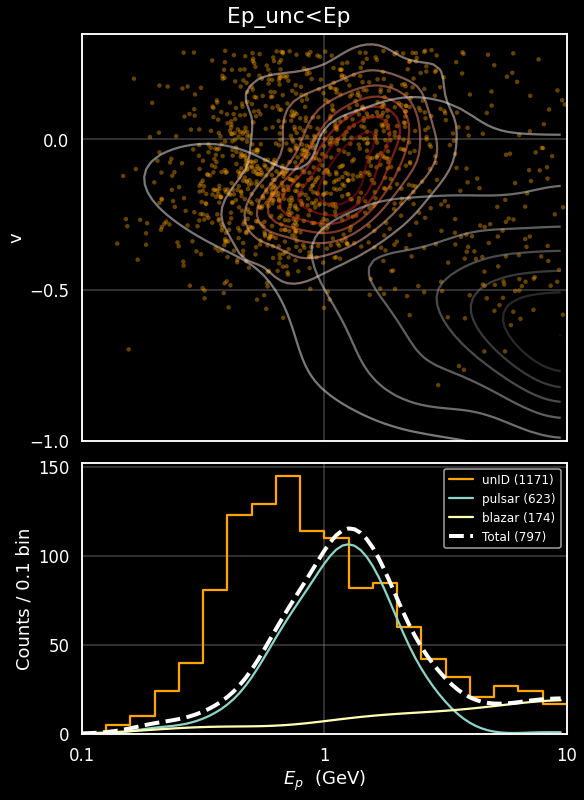

### bw_method=0.8 

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f252c11e740>
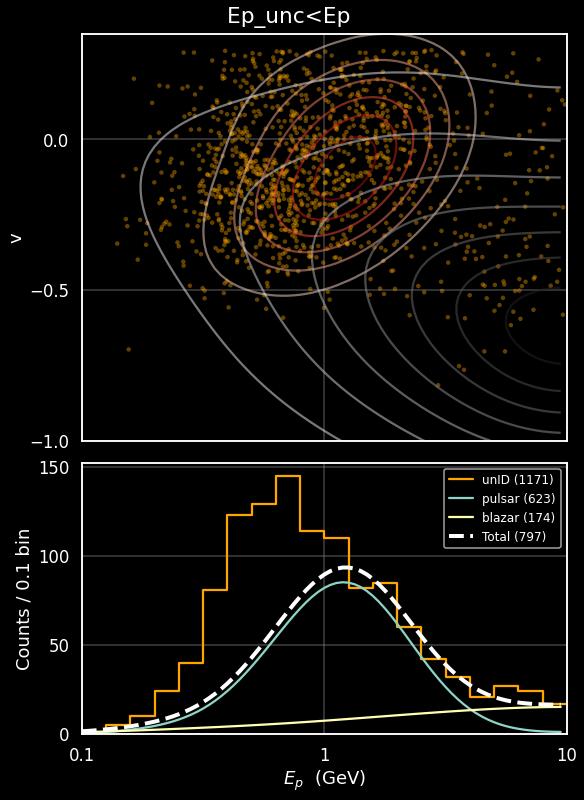

In [2]:
show(f"""# Set pulsar, blazar norms to {(norms:=[623,174])} from Galacticity
## Select {(cut:='Ep_unc<Ep')}""")

for bw_method in [None, 0.8]:
    self = KDEuv(data.query(cut),
             title=cut,bw_method=bw_method)
    show(f"""### {bw_method=} """)
    show_fig(self.scat_plot, norms=norms)

# self = KDEuv(data.query((cut:='Ep>0.12 & Ep_unc/Ep<1 ')),
#              title=cut,bw_method=(bw_method:=0.75))
# show(f"""## * {bw_method=} """)
# show_fig(self.scat_plot, norms=norms)

# Examine weight distribution

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f252e3085b0>
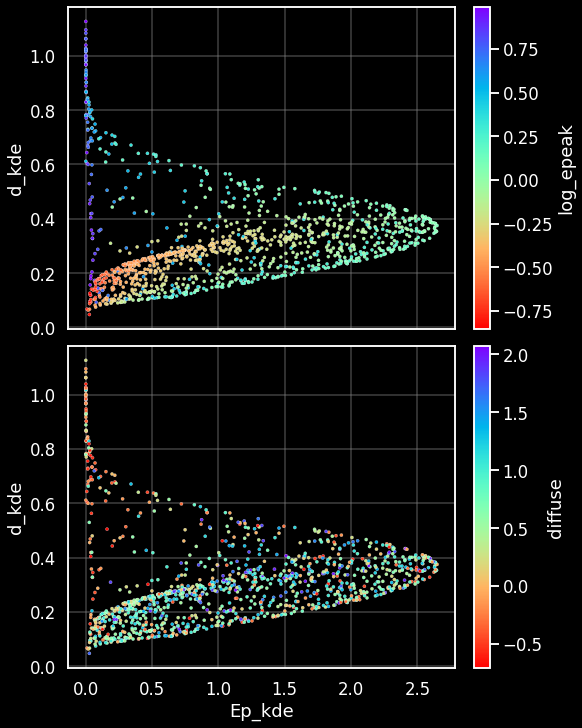

In [3]:
show(f"""# Examine weight distribution""")

def kde_scat(self, z, ax=None, cmap='rainbow_r'):
    p, b = self['pulsar'], self['blazar']
    u = self.unid
    uz = u[z]
    fig, ax = plt.subplots(figsize=(7,5)) if ax is None else (ax.figure,ax)
    sns.scatterplot(u,ax=ax, x=p(u), y=b(u), s=10, c=uz, cmap=cmap );
    norm = plt.Normalize( uz.min(), uz.max() )
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    ax.set(xlabel='Ep_kde', ylabel='d_kde')
    cb = plt.colorbar(sm, ax=ax)
    cb.set_label(z)
    return fig

fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(8,10), sharex=True)
kde_scat(self, 'log_epeak', ax=ax1)
kde_scat(self, 'diffuse', ax=ax2)
show(fig)

In [4]:
show('---')
assert False, 'Stop here'

---

AssertionError: Stop here

In [ ]:
fig, axx = plt.subplots(2,2, figsize=(11,11), sharex=True, sharey=True,
                              height_ratios=(2,4), width_ratios=(4,2))
axx[0,1].set_visible(False);

In [ ]:
show(f"""### KDE contour plots: sns.kdeplot""")
# dfuv = data.copy()
# dfuv['u'] = dfuv.log_epeak
# dfuv['v'] = dfuv.log_d
fig, ax = plt.subplots(figsize=(8,6))
for key in 'blazar pulsar'.split():
    sns.kdeplot(data.groupby('trainer').get_group(key), ax=ax,
                x='log_epeak', y='log_d',   label=key)
ax.legend();
f = lambda x: x-0.2 #+ 0.5*(x-0.2)**2
ax.plot(x:=np.array([-1,0.8]),f(x), '--r')
ax.axhline(np.log10(2), ls='--', color='grey')
ax.set(aspect=1)
show(fig)

In [ ]:
train_cut = '0.1<d<1.9 & Ep>0.11'
train_grp = data.query(train_cut).groupby('trainer')
trainers = 'pulsar blazar'.split()
kde_dict = dict( (key, Gaussian_kde(train_grp.get_group(key), features)) 
     for key in 'blazar pulsar'.split())
# show(f"""$\\rightarrow$ ({kde_dict['blazar']},<br>{kde_dict['pulsar']}) """)
show(f"""## 2-D training, cut {train_cut}
* {kde_dict['blazar']},<br>{kde_dict['pulsar']} """)

In [ ]:
def unid_with_contours(data, unid, features, ax=None):
    kde_dict = dict( (key, Gaussian_kde(data.groupby('trainer').get_group(key), features)) 
         for key in trainers)
    mgx, mgy = np.meshgrid(np.arange(-1,1.2,0.025), np.arange(-1.2,0.5,0.025))
    fig, ax = plt.subplots(figsize=(9,8)) if ax is None else (ax.figure, ax)
    for key in 'pulsar'.split():
        fn = kde_dict[key].evaluate    
        z = fn((mgy.flatten(), mgx.flatten())).reshape(mgx.shape)
        ax.contour(mgx, mgy,z,  cmap='viridis')
      
    sns.scatterplot((df:=unid), #.query('Ep_unc/Ep<0.5'),
                    ax=ax, x='log_epeak', y='log_d', #'sqrt_d',
                    s=20, edgecolor='none', color='orange',
                     #hue='unid_type', hue_order='unID bcu_unk'.split(),palette=['0.5', 'red'],                
                    alpha=0.4,label='unID')#legend=False);
    ax.set(**epeak_kw(), xlim=(-1,1), 
           ylabel='$d$', yticks=np.log10([0.1,0.3,1,2]),
               yticklabels='0.1 0.3  1 2'.split(), 
           ylim=(-1, np.log10(2.2)),           
          )

    ax.axhline(np.log10(2), ls='--', color='grey')  
    ax.legend(loc='upper left')
    # ax.plot(np.log10([0.1,1,1]), np.log10([0.3, 0.3, 2]), 'r', ls='--')
    ax.axhline(np.log10(0.3), color='r',ls = '--')
    ax.axvline(np.log10(1), color='r', ls='--')
    return fig

fig, ax = plt.subplots(figsize=(7,5))
# ax.axhline(np.log10(0.3), ls='--', color='0.3', lw=0.5 )
show_fig(unid_with_contours, data, unid,  features, ax=ax, 
     save_to='figures/spectral_shape/unid_with_contours.png',  facecolor='k')

In [ ]:
def multi_unid_contour(data, unid):
    fig, axx = plt.subplots(ncols=3, figsize=(18,6))
    for ax, cut in zip(axx.flat, ['significance<6','10>significance>6', 'significance>10', 
                              ]):
        df = unid.query(cut)
        unid_with_contours( data, df,  features, ax=ax, )
        ax.set_title(cut+f' ({len(df)})');
    return fig
show_fig(multi_unid_contour, data, unid)
    # save_to='figures/spectral_shape/unid_with_contours.png',  facecolor='k')

In [ ]:
show(f"""###  unID cut "{(cut:='0.4<d<1.9 & Ep>0.12')}" """)   
# ax.legend(loc='upper left', fontsize=12, title='unid type')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(9,10), sharex=True, height_ratios=(2,1),)

unid_with_contours( data, unid.query(cut),  features, ax=ax1,) 
#save_to='figures/spectral_shape/unid_with_contours.png',        facecolor='k')
cut_unid = unid.query(cut)

sns.histplot(cut_unid, ax=ax2, x='log_epeak',bins=np.arange(-1, 1.1, 0.1),
             stat='count', element='step', fill=False, color='orange', label=f'unID {len(cut_unid)}')


kde_ep = dict((key, Gaussian_kde(train_grp.get_group(key).query(cut), ['log_epeak'], bw_method=1.2))
              for key in trainers)
show(f"""#### 1-D KDE<br>{kde_ep}""")
ep_list =np.arange(-1,1,0.05)

ktbl = pd.DataFrame.from_dict(
    dict( (name, kde_ep[name].evaluate(ep_list))  for name in trainers )
)
factors = np.array([673, 342])*0.1
for src, factor, color in zip(trainers, factors, 'cyan 0.5'.split()):
    sns.lineplot(ax=ax2, x=ep_list, y = ktbl[src]*factor, color=color, label=src+f' ({factor*10:.0f})'); 
sns.lineplot(ax=ax2, x=ep_list, y =(ktbl * factors) .sum(axis=1), color='w', lw=4, ls='--',label='Total') 
ax2.set(**epeak_kw(), xlim=(-1,1))
show(fig)

In [ ]:
class KDEuv(dict):
    kde_binsize=0.025
    unid_binsize=0.1
    norm = 1/kde_binsize**2
    x_grid, y_grid =(np.arange(-1,1,kde_binsize), np.arange(-1,0.5,kde_binsize))
    unid_bins = np.arange(-1,1.01,unid_binsize)
    trainers=['pulsar', 'blazar']
    
    def __init__(self, data, transform=True):
    
        # initial selection
        self.dfuv = dfuv = data.copy()

        # centered log_epeak and log_d
        xp, yp = self.dfuv.log_epeak-0.085, dfuv.log_d+0.12
        xp, yp = self.dfuv.log_epeak, dfuv.log_d
        if transform :
            dfuv['u'] =  xp - 0.6 * yp 
            dfuv['v'] =  1.5 * yp    
        else:
            dfuv['u'] = xp
            dfuv['v'] = yp # 1.5* yp
        self.unid = self.dfuv.query('association=="unID"')
        
        # create 2-D KDE with rescaled, adjusted variables 
        self.update( 
            dict( (key, Gaussian_kde(dfuv.groupby('trainer').get_group(key),  ['v','u'])  ) for key in self.trainers)
        )

        # evaluate the KDE functions on a 2-D grid
        self.grids ={}
        xg, yg = self.x_grid, self.y_grid
        for tr in self.trainers:
            fp = self[tr]
            self.grids[tr] = pd.DataFrame(
                [[fp.evaluate((y,x)) for x in xg] for y in yg], index=yg, columns=xg).astype(float)
         
    def plot_kde_contours(self,  ax,
                          cmaps ='Reds Greens'.split(), alpha=0.5 ):
        
        x,y = self.x_grid, self.y_grid
        for (key,grid), cmap in zip(self.grids.items(), cmaps):
            ax.contour(x,y, grid, cmap=cmap,  alpha=alpha);

    def plot_unid(self, ax1, ax2, cut='', **kwargs):
        # scatter and hist
        unid = self.unid.query(cut) if cut else self.unid
        sns.scatterplot(unid, #.query('Ep_unc/Ep<0.5'),
                ax=ax1, x='u', y='v', 
                s=20, edgecolor='none', color='orange',
                alpha=0.4,legend=False);
        
        sns.histplot(unid, bins=self.unid_bins,
                     ax=ax2, x='u', element='step', fill=False, color='orange', **kwargs)
        ax2.set(ylabel=f'Counts / {self.unid_binsize} bin', yticks=np.arange(0,151,50),)

    def scat_plot(self, norms ):
        fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(8,11), sharex=True, height_ratios=(3,2))
        ax1.set(xlim=(-1,1), ylim=(-1, 0.35), yticks=np.arange(-1,0.5,0.5), xticks=np.arange(-1,1.01,0.5),)
        self.plot_kde_contours(ax1, cmaps='Reds Greys'.split())
        
        self.plot_unid(ax1, ax2,(q:=''), label=f'unID ({len(self.unid)})')
        x = self.x_grid
        total = np.zeros(len(x))
        for train, norm in zip(self.keys(), norms):
            g = self.grids[train]
            # integral over curvature, per unid bins
            y = g.sum(axis=0)*self.kde_binsize * norm * self.unid_binsize
            ax2.plot(x,y, label=train+f' ({norm})')
            total += y
        ax2.plot(x, total, lw=4, color='w', ls='--', label=f'Total ({sum(norms)})')
        ax2.set(**epeak_kw())
        ax2.legend(fontsize=12)
        
        fig.suptitle(cut+' '+q)
        return fig

self = KDEuv(data.query((cut:='Ep>0.12 & Ep_unc/Ep<1')), transform=False)
show_fig(self.scat_plot, norms=[450,270])

In [ ]:
len(total),sum(total)/10 #, max(p.sum(axis=0))/self.norm*10 * 200
# plt.plot(total);

In [ ]:
p, b = self.grids['pulsar'], self.grids['blazar']
show(f"""* Check total integrals: 
{[(np.sum(x.sum())/self.norm).round(3) for x in (p,b)] } for pulsar, blazar
""")
# py = p.sum(axis=1)*self.binsize
px = p.sum(axis=0)*self.binsize
bx = b.sum(axis=0)*self.binsize

plt.figure(figsize=(8,5))
plt.plot(self.x_grid, px*(npp:=450)/10 , label=f'pulsar ({npp})'); 
plt.plot(self.x_grid, bx*(nbb:=270)/10 , label=f'blazar ({nbb})'); 

plt.plot(self.x_grid, (px*npp+bx*nbb)/10 , label=f'Total ({nbb+npp})'); 

sns.histplot(self.unid, x='u', bins=np.arange(-1,1.01,0.1), element='step', fill=False,
            label=f'unID ({len(self.unid)})')

plt.legend(fontsize=12)
plt.show()
# plt.plot(self.y_grid,p1)

In [ ]:
show(f"""## Compare blazar and unid $E_p$ with $d<{(dcut:=0.3)}$ """)
fig, ax = plt.subplots(figsize=(6,4))
hkw = dict(x='log_epeak', ax=ax, stat='density',bins=np.arange(-1,1.01,0.1), element='step', fill=False,)
hkw=dict(x='log_epeak',)
sns.kdeplot(grps.get_group('blazar').query(f'd<{dcut}'),  **hkw, label='blazar');
sns.kdeplot(unid.query(f'd<{dcut}'), **hkw, label='unID')
ax.legend(fontsize=12)
ax.set(**epeak_kw())
show(fig)

In [ ]:
show(f"""### $Ep_{{unc}}/Ep$ vs $Ep$ for {(cut:='d<0.3')}""")
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(6,8), sharex=True)
sns.scatterplot((df:=grps.get_group('blazar').query(f'{cut}')), ax=ax1, y=df.Ep_unc/df.Ep, x='log_epeak', s=10).set(
        ylim=(0,2), title='blazars');
sns.scatterplot((df:=unid.query(f'{cut}')), ax=ax2, y=df.Ep_unc/df.Ep, x='log_epeak', s=10).set(
        ylim=(0,2), title='unID');
ax2.set(**epeak_kw())
show(fig)

In [ ]:
show(f"""### $Ep_{{unc}}/EP$ vs $Ep$ for {(cut:='d>0.3 ')}""")
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(6,8), sharex=True)
sns.scatterplot((df:=grps.get_group('blazar').query(f'{cut}')), ax=ax1, y=df.Ep_unc/df.Ep, x='log_epeak', s=10).set(
        ylim=(0,2), title='blazars');
sns.scatterplot((df:=unid.query(f'{cut}')), ax=ax2, y=df.Ep_unc/df.Ep, x='log_epeak', s=10).set(
        ylim=(0,2), title='unID');
ax2.set(**epeak_kw())
show(fig)

In [ ]:
show(f"""## Compare with the unID galacticity probabilities""")
df_kde = pd.DataFrame.from_dict(
    dict( (key, kde_dict[key](unid)) for key in 'pulsar blazar'.split()),  )
df_kde.index = unid.index


show(f"""### Some probability correlations""")
fig, ax= plt.subplots(figsize=(6,6))
sns.scatterplot(ax=ax, x=df_kde['blazar'], y=gprob.blazar, s=20, edgecolor='none');
ax.set(xlabel='KDE', ylabel='galacticity', title='blazar');
show(fig)

fig, ax= plt.subplots(figsize=(6,6))
sns.scatterplot(ax=ax, x=df_kde.pulsar, y=gprob.pulsar, s=20, edgecolor='none');
ax.set(xlabel='kde_pulsar', ylabel='galacticity_pulsar');
show(fig)

fig, ax= plt.subplots(figsize=(6,6))
sns.scatterplot(ax=ax, x=df_kde.pulsar, y=gprob.blazar, s=20, edgecolor='none');
ax.set(xlabel='kde_pulsar', ylabel='galacticity_blazar');
show(fig)

In [ ]:
show(f"""### Display using plt.contour with unID overlay""")
mgx, mgy = np.meshgrid(np.arange(-1,1.2,0.025), np.arange(0,1.5,0.025))
fig, ax = plt.subplots(figsize=(8,8))
for key in 'blazar pulsar'.split():
    fn = kde_dict[key].evaluate    
    z = fn((mgy.flatten(), mgx.flatten())).reshape(mgx.shape)
    ax.contour(mgx, mgy,z,  cmap='viridis')
sns.scatterplot(unid.query('Ep_unc/Ep<0.5 & d_unc<0.5'),
            ax=ax,x='log_epeak', y='d', s=30, edgecolor='none',
             hue='unid_type', hue_order='unID bcu_unk'.split(),palette=['0.5', 'red'],                
            alpha=0.6,label='unID');
ax.set(**epeak_kw(),  xlim=(None,1), yticks=np.arange(0,2.01,0.5))
ax.legend(loc='upper left', fontsize=12, title='unid type')
show(fig)